In [1]:
import pickle
import numpy as np
import pandas as pd
import random
import json
import math
import copy
import urllib
from shapely.geometry import Point, shape
import time
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import copy

## Functions

In [18]:
def get_haversine_distance(point_1, point_2):
    """
    Calculate the distance between any 2 points on earth given as [lon, lat]
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [point_1[0], point_1[1], 
                                                point_2[0], point_2[1]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_LLs(persons, places):
    """ takes a list of person objects and 
    finds home and work coordinates for them
    modifies in place
    """
    for p in persons:  
        for place in places:
            geoid=p[place+'_geoid']
            if 'g' in str(geoid):
                ll=grid_points_ll[int(geoid[1:])]
            else:
                ll=[all_geoid_centroids[geoid][0]+np.random.normal(0, 0.002, 1)[0], 
                    all_geoid_centroids[geoid][1]+np.random.normal(0, 0.002, 1)[0]]
            p[place+'_ll']=ll

def create_long_record_1(person, house, choice_id):
    """ 
    Only work for 1-stage home location choice simulation
    
    takes a house object and a household object and 
    creates a row for the MNL long data frame 
    """
    beds=min(3, max(1, house['beds']))
    norm_rent=(house['rent']-rent_normalisation['mean'][str(int(beds))])/rent_normalisation['std'][str(int(beds))]
    return {'norm_rent': norm_rent,
            'work_dist': get_haversine_distance(person['work_ll'], house['centroid']),
            'puma_pop_per_sqmeter': house['puma_pop_per_sqmeter'],
            'income_disparity': np.abs(house['puma_med_income']-person['HINCP']),
            'built_since_jan2010': house['built_since_jan2010'],
            'custom_id': person['person_id'],
            'choice_id': choice_id,
            'actual_house_id':house['house_id']}

def home_location_choices_1(houses, persons):
    """ 
    1-stage home location choice simulation
    
    takes the house and person objects
    finds the vacant houses and homeless persons
    chooses a housing unit for each person
    modifies the house and person objects in place
    """
    long_data=[]
    # for each household, sample N potential housing choices
    # and add them to the long data frame
    for p in persons:
        #choose N houses
        h_alts=random.sample(houses, 9)
        for hi, h in enumerate(h_alts):
            long_record=create_long_record_1(p, h, hi+1)
            long_data.append(long_record)             
#             long_data.append(h.long_data_record(hh.hh_income, hh.household_id, hi+1, rent_normalisation))
    long_df=pd.DataFrame(long_data)
    # TODO: why do some houses have nan for norm_rent
    long_df.loc[long_df['norm_rent'].isnull(), 'norm_rent']=0
    long_df['predictions']=home_loc_logit.predict(long_df)
    for p_ind in set(long_df['custom_id']):
        # find maximum prob or sample from probs in subset of long_df
        house_id=np.random.choice(long_df.loc[long_df['custom_id']==p_ind, 'actual_house_id'], 
                                  p=long_df.loc[long_df['custom_id']==p_ind, 'predictions'])
        persons[p_ind]['house_id']=house_id
        persons[p_ind]['home_geoid']=houses[house_id]['home_geoid']
        # update characterictics of persons in these households

def utility_to_prob(v):
    """
    Auxiliary function
    takes a utility vector and predicts probability 
    """
    v = v - v.mean()
    v[v>700] = 700
    v[v<-700] = -700
    expV = np.exp(v)
    p = expV / expV.sum()
    return p
    
def unique_ele_and_keep_order(seq):
    """ 
    Auxiliary function
    same as list(set(seq)) while keep element order 
    """
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
    
def pylogit_pred(data, modelDict, customIDColumnName, even=True):
    """ 
    Auxiliary function
    predicts probabilities for pylogit models,
    this function is needed as the official 'predict' method cannot be used when the choice sets 
    in predicting is not exactly the same as in trainning,
    argument even: whether each choice situation has the same number of alternatives
    """
    # fectch variable names and parameters 
    if modelDict['just_point']:
        params, varnames = modelDict['params'], modelDict['var_names']
    else:
        params, varnames = list(modelDict['model'].coefs.values), list(modelDict['model'].coefs.index)
    # calc utilities
    data['utility'] = 0
    for varname, param in zip(varnames, params):
        data['utility'] += data[varname] * param
    # calc probabilities given utilities
    # if every choice situation has the same number of alternatives, use matrix, otherwise use list comprehension
    if even:
        numChoices = len(set(data[customIDColumnName]))
        v = np.array(data['utility']).copy().reshape(numChoices, -1)
        v = v - v.mean(axis=1, keepdims=True)  
        v[v>700] = 700
        v[v<-700] = -700
        expV = np.exp(v)
        p = expV / expV.sum(axis=1, keepdims=True)
        return p.flatten()
    else:
        uniqueCustomIDs = unique_ele_and_keep_order(data[customIDColumnName])
        vArrayList = [np.array(data.loc[data[customIDColumnName]==id, 'utility']) for id in uniqueCustomIDs]
        pArrayList = [utility_to_prob(v) for v in vArrayList]
        return [pElement for pArray in pArrayList for pElement in pArray ]
    

def create_long_record_puma(person, puma):
    """ 
    Only work for 2-stage home location choice simulation: puma level
    takes a puma object and a household object and 
    creates a row for the MNL long data frame 
    """
    return   {'puma_pop_per_sqm': puma['puma_pop_per_sqm'],
              'income_disparity': np.abs(person['HINCP'] - puma['med_income']),
              'work_dist': get_haversine_distance(person['work_ll'], puma['centroid']),
              'media_norm_rent': puma['media_norm_rent'],
              'num_houses': puma['num_houses'],
              'entertainment_den': puma['entertainment_den'],
              'medical_den': puma['medical_den'],
              'school_den': puma['school_den'],
              'custom_id': person['person_id'],
              'choice_id': puma['puma']} 

def create_long_record_house(person, house, choice_id):
    """ 
    Only work for 2-stage home location choice simulation: housing unit level
    takes a house object and a household object and 
    creates a row for the MNL long data frame 
    """
    beds=min(3, max(1, house['beds']))
    norm_rent=(house['rent']-rent_normalisation['mean'][str(int(beds))])/rent_normalisation['std'][str(int(beds))]
    record = {'norm_rent': norm_rent,
            'built_since_jan2010': house['built_since_jan2010'],
            'bedrooms': house['beds'],
            'income': person['HINCP'],
            'custom_id': person['person_id'],
            'choice_id': choice_id,
            'actual_house_id':house['house_id']} 
    nPersons = 0
    if person['workers'] == 'one':
        nPersons += 1
    elif person['workers'] == 'two or more':
        nPersons += 2
    if person['children'] == 'yes':
        nPersons += 1
    if nPersons == 0:
        nPersons = 1
    record['nPersons'] = nPersons
    return record    
    
    
def home_location_choices_2(houses, persons):
    """ 
    2-stage home location choice simulation
    takes the house and person objects
    finds the vacant houses and homeless persons
    chooses a housing unit for each person
    modifies the house and person objects in place
    """
    valid_pumas = list(set([h['puma10'] for h in houses])) 
    valid_puma_objs = [copy.deepcopy(puma_obj_dict[puma]) for puma in valid_pumas]
    puma_to_houses = {puma: [h for h in houses if h['puma10']==puma] for puma in valid_pumas}
    for h in houses:        # updating number of houses in each puma given new houses
        if h['home_geoid'].startswith('g'):
            puma_index = valid_pumas.index(h['puma10'])
            valid_puma_objs[puma_index]['num_houses'] += 1
    # stage1: PUMA choice
    long_data_puma = []
    for p in persons:
        for puma in valid_puma_objs:
            this_sample_long_record_puma = create_long_record_puma(p, puma)
            long_data_puma.append(this_sample_long_record_puma)
    long_df_puma = pd.DataFrame(long_data_puma)
    home_loc_mnl_puma = home_loc_logit['home_loc_mnl_PUMAs']
    long_df_puma['predictions'] = pylogit_pred(long_df_puma, home_loc_mnl_puma, 'custom_id', even=True) 
    if top_n_pumas is None:
        custom_specific_long_df_puma = {custom_id: group for custom_id, group in long_df_puma[['custom_id', 'choice_id', 'predictions']].groupby('custom_id')}
    else:
        long_df_puma_sorted = long_df_puma[['custom_id', 'choice_id', 'predictions']].sort_values(['custom_id','predictions'], ascending=[True, False])
        custom_specific_long_df_puma = {custom_id: group.iloc[:top_n_pumas,:] for custom_id, group in long_df_puma_sorted.groupby('custom_id')}
    for p_ind in set(long_df_puma['custom_id']):
        if top_n_pumas is None:
            house_puma=np.random.choice(custom_specific_long_df_puma[p_ind]['choice_id'], p=custom_specific_long_df_puma[p_ind]['predictions'])
        else:
            house_puma=np.random.choice(custom_specific_long_df_puma[p_ind]['choice_id'], 
                                        p=custom_specific_long_df_puma[p_ind]['predictions'] / custom_specific_long_df_puma[p_ind]['predictions'].sum())
        persons[p_ind]['house_puma'] = house_puma
    # stage2: housing unit choice
    long_data_house = []
    even = True  # use "even" to monitor if every choice situation has the same number of alternatives
    for p in persons:
        houses_in_puma = puma_to_houses[p['house_puma']]
        if len(houses_in_puma) < 9:
            house_alts = houses_in_puma 
            even = False
        else:
            house_alts = random.sample(houses_in_puma, 9)
        for hi, h in enumerate(house_alts):
            this_sample_long_record_house = create_long_record_house(p, h, hi+1)
            long_data_house.append(this_sample_long_record_house)             
    long_df_house = pd.DataFrame(long_data_house)
    long_df_house.loc[long_df_house['norm_rent'].isnull(), 'norm_rent']=0
    long_df_house['income_norm_rent'] = long_df_house['income'] * long_df_house['norm_rent']
    long_df_house['income_bedrooms'] = long_df_house['income'] * long_df_house['bedrooms']
    long_df_house['nPerson_bedrooms'] = long_df_house['nPersons'] * long_df_house['bedrooms']
    home_loc_mnl_house = home_loc_logit['home_loc_mnl_hh']
    long_df_house['predictions'] = pylogit_pred(long_df_house, home_loc_mnl_house, 'custom_id', even=even)
    custom_specific_long_df_house = {custom_id: group for custom_id, group in long_df_house[['custom_id', 'actual_house_id', 'predictions']].groupby('custom_id')}
    for p_ind in set(long_df_house['custom_id']):
        house_id = np.random.choice(custom_specific_long_df_house[p_ind]['actual_house_id'], 
                                    p=custom_specific_long_df_house[p_ind]['predictions'])             
        persons[p_ind]['house_id']=house_id
        persons[p_ind]['home_geoid']=houses[house_id]['home_geoid']
        
        
def home_location_choices_for_single_person(houses, person):
    """ 
    2-stage home location choice simulation for single person
    used for simulations considering DYNAMIC occupancy and availability of houses
    houses is no longer a list, but a dict with house_id as the key for each house obj
    """
    # stage1: PUMA
    t1 = time.time()
    valid_pumas = list(set([h['puma10'] for house_id, h in houses.items()]))
    valid_puma_objs = [copy.deepcopy(puma_obj_dict[puma]) for puma in valid_pumas]
    puma_to_houses = {puma: [hobj for hid, hobj in houses.items() if hobj['puma10']==puma] for puma in valid_pumas}
    for hid, hobj in houses.items():        # updating number of houses in each puma given new houses
        if hobj['home_geoid'].startswith('g'):
            puma_index = valid_pumas.index(hobj['puma10'])
            valid_puma_objs[puma_index]['num_houses'] += 1
    long_data_puma = []
    for puma in valid_puma_objs:
        this_sample_long_record_puma = create_long_record_puma(person, puma)
        long_data_puma.append(this_sample_long_record_puma)
    long_df_puma = pd.DataFrame(long_data_puma)
    t2 = time.time()
    # prediction
    home_loc_mnl_puma = home_loc_logit['home_loc_mnl_PUMAs']
    puma_prob = pylogit_pred(long_df_puma, home_loc_mnl_puma, 'custom_id', even=True) 
    t3 = time.time()
    house_puma=np.random.choice(valid_pumas, p=puma_prob)
    person['house_puma'] = house_puma
    t4 = time.time()    
    
    # stage2: housing unit
    long_data_house = []
    houses_in_puma = [h for house_id, h in houses.items() if h['puma10']==house_puma]
    if len(houses_in_puma) < 9:
        house_alts = houses_in_puma
    else:
        house_alts = random.sample(houses_in_puma, 9)
    for hi, h in enumerate(house_alts):
        this_sample_long_record_house = create_long_record_house(person, h, hi+1)
        long_data_house.append(this_sample_long_record_house)             
    long_df_house = pd.DataFrame(long_data_house)
    long_df_house.loc[long_df_house['norm_rent'].isnull(), 'norm_rent']=0
    long_df_house['income_norm_rent'] = long_df_house['income'] * long_df_house['norm_rent']
    long_df_house['income_bedrooms'] = long_df_house['income'] * long_df_house['bedrooms']
    long_df_house['nPerson_bedrooms'] = long_df_house['nPersons'] * long_df_house['bedrooms']
    t5 = time.time()

    home_loc_mnl_house = home_loc_logit['home_loc_mnl_hh']
    house_prob = pylogit_pred(long_df_house, home_loc_mnl_house, 'custom_id', even=True)
    t6 = time.time()
    house_id=np.random.choice(long_df_house['actual_house_id'], p=house_prob)
    person['house_id']=house_id
    person['home_geoid']=houses[house_id]['home_geoid']
    t7 = time.time()
    timestrList = [
        'stage 1 data preparing: {:4.2f}s'.format(t2-t1),
        'stage 1 probability prediction: {:4.2f}s'.format(t3-t2),
        'stage 1 outcome prediction: {:4.2f}s'.format(t4-t3),
        'stage 2 data preparing: {:4.2f}s'.format(t5-t4),
        'stage 2 probability prediction: {:4.2f}s'.format(t6-t5),
        'stage 2 outcome prediction: {:4.2f}s'.format(t7-t6),
    ]
#     print('\n\n--------------------------------------------------------')
#     print('\n'.join(timestrList))
#     print('--------------------------------------------------------\n\n')
    return house_id

## Constants

In [3]:
city = 'Detroit'

# HOME_lOC_DATA_PATH stored: data = {'persons':floating_persons, 'houses':vacant_houses}
HOME_lOC_DATA_PATH = r'C:\0 - MIT\02 - mobility\ford\home_location_choice_simulation_from10-30\hlc_data_3.p'

GRID_INT_SAMPLE_PATH='./scripts/cities/'+city+'/clean/grid_interactive.geojson'
RENT_NORM_PATH = './scripts/cities/'+city+'/models/rent_norm.json'
rent_normalisation=json.load(open(RENT_NORM_PATH))

PUMA_ATTR_PATH = './scripts/cities/'+city+'/models/puma_attr.json'
PUMA_SHAPE_PATH='./scripts/cities/'+city+'/raw/PUMS/pumas.geojson'
PUMAS_INCLUDED_PATH='./scripts/cities/'+city+'/raw/PUMS/pumas_included.json'

ALL_ZONES_PATH='./scripts/cities/'+city+'/clean/model_area.geojson'
SIM_ZONES_PATH='./scripts/cities/'+city+'/clean/sim_zones.json'
all_geoid_centroids = pickle.load(open(r'C:\0 - MIT\02 - mobility\ford\all_geoid_centroids.p', 'rb'))

## Preparing

In [4]:
# geo files
all_zones_df = gpd.read_file(ALL_ZONES_PATH)
sim_zones=json.load(open(SIM_ZONES_PATH))
sim_zones_pd = all_zones_df[all_zones_df['GEO_ID'].isin(sim_zones)].copy()

# interactive grid
host='https://cityio.media.mit.edu/'
cityIO_grid_url=host+'api/table/corktown'
try:
    with urllib.request.urlopen(cityIO_grid_url+'/grid_interactive_area') as url:
        grid_interactive=json.loads(url.read().decode())
except:
    print('Using static cityIO grid file')
    grid_interactive=json.load(open(GRID_INT_SAMPLE_PATH))
grid_points_ll=[f['geometry']['coordinates'][0][0] for f in grid_interactive['features']]

# create a lookup from interactive grid to puma

puma_shape=json.load(open(PUMA_SHAPE_PATH))
puma_order=[f['properties']['PUMACE10'] for f in puma_shape['features']]
puma_included=json.load(open(PUMAS_INCLUDED_PATH)) 
puma_shape_dict = {feature["properties"]["GEOID10"][2:]: shape(feature["geometry"]) 
                   for feature in puma_shape['features'] if feature["properties"]["GEOID10"][2:] in puma_included}
int_grid_to_puma = {'g'+str(grid_id): None for grid_id in range(len(grid_points_ll))}
for grid_id, grid_point_ll in enumerate(grid_points_ll):
    for puma_id, puma_polygon in puma_shape_dict.items():
        if puma_polygon.contains(Point(grid_point_ll[0], grid_point_ll[1])):
            int_grid_to_puma['g'+str(grid_id)] = puma_id
            break
            
# create puma objects
puma_df = pd.DataFrame(json.load(open(PUMA_ATTR_PATH, 'r')))
puma_obj_dict = {}
for puma in puma_df.index:
    this_obj = puma_df.loc[puma].to_dict()
    this_obj['puma'] = puma
    centroid = shape(puma_shape['features'][puma_order.index(puma)]['geometry']).centroid
    this_obj['centroid'] = [centroid.x, centroid.y]
    puma_obj_dict[puma] = this_obj

# Comparison: 1-stage simulation and 2-stage simulation

There is a trick in 2-stage simualtion.

When estimating home location choice model, we only know spatial information at PUMA level. From this respect, it is safer to use home-work distance at PUMA level rather than housing unit level. PUMS data only show that a person work in a certain PUMA tends to reside in the same or neighboring PUMA, but we cannot know to what extent a person would prefer a single house with less distance to his working place. Therefore, the 2-stage model/simulation only use home-work distance at PUMA level, not at housing unit level. Although distance should also play a part at housing unit level, unfortunately, its effect can not be quantified, as all houses in a certain PUMA would have no difference in term of distance. In this manner, 2-stage simulation is hoped to show a picture that most people choose their homes in a reaonable range from the workplaces, but not necessarily like the near the better.

However, a practical problem is that PUMAs seem to be overlarge for our scale, and there are still 10+ PUMAs for each PUMA choice situation. It is not a suprise that a person happens to choose a distant house, that's because: (1) the cummulated probability of choosing relatively distant PUMA is not trivial, due to large number of PUMAs; (2) even the 2nd nearest PUMA is chosen, it is still distant compared with 1st nearst PUMA, due to large scale of PUMAs; (3) there is no priority for a nearby house inside the chosen PUMA, since housing-unit-level model does not include distance. On the other side, choosing distant houses in 1-stage simulation is pretty normal, as the alternatives are randomly sampled without distance control. Consequently, sometimes the results of 1-stage and 2-stage simulations may look similar. 

To make an improvement, a trick is added to 2-stage simulation by the constant "top_n_pumas". When choosing a PUMA, only top n PUMAs with the largest prabilities are considered. For instance, top_n_pumas=1 has the same effect as finding the maximum probability. Besides, top_n_pumas=None will skip this trick and consider all PUMAs. Some experiments indicate that the simulation results yielded by this approach looks more reasonable, and thus it is used in "abm.py" with top_n_pumas set to 5.

In the following cells, different simulation results are compared through visualization, mean distance, and running time. All of them used the same set of floating persons and vacant houses derived from the landuse plan given by https://cityio.media.mit.edu/api/table/corktown/grid. To my intuition, 2-stage simulation with top_n_pumas=5 yields more reasonable choice outcomes than others.

As to running time, 1-stage simulation is apparently fastest. I made several modifications so that 2-stage simulation is also computationally affordable. Besides, I tried to consider the dynamic availability of vacant houses to make sure a house could only serve one person, however, it seems that a loop over all persons to make choices one by one is a must. The final cell does this and unfortunately consumes too much time. 

## 1-stage simulation 

1-stage simulation elapsed time: 0.5016 seconds
1-stage simulation mean work-home distance: 12149.43


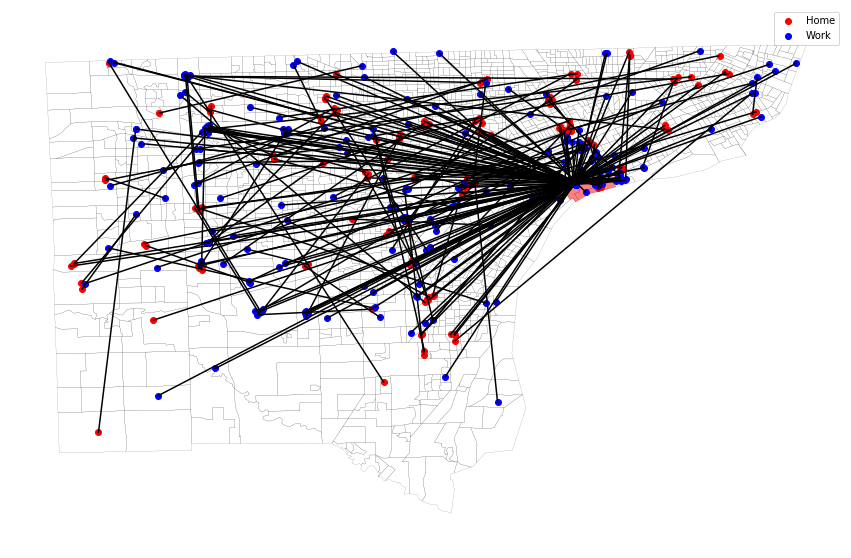

In [5]:
# =============================================================================
# Home location choice simulation using 1-stage model
# =============================================================================
# loading data and model
data = pickle.load(open(HOME_lOC_DATA_PATH, "rb"))
vacant_houses, floating_persons = data['houses'], data['persons']
FITTED_HOME_LOC_MODEL_PATH='./scripts/cities/'+city+'/models/home_loc_logit_1.p'
home_loc_logit=pickle.load( open( FITTED_HOME_LOC_MODEL_PATH, "rb" ) )

# simulation
t1 = time.time()
home_location_choices_1(vacant_houses, floating_persons)
t2 = time.time()
time_1stage = t2 - t1
print('1-stage simulation elapsed time: {:4.4f} seconds'.format(time_1stage))

# visualization
f, ax1 = plt.subplots(1, 1,figsize=(15,10))
get_LLs(floating_persons, ['home'])
all_zones_df.plot(ax = ax1, facecolor="none", edgecolor="black", linewidth=0.1)      
sim_zones_pd.plot(ax = ax1, facecolor='red', alpha=0.5, edgecolor="black", linewidth=0.1)
ax1.axis('off') 
ax1.axis('equal')
home_points, work_points, dist = [], [], []
for p in floating_persons:
    home_points.append(p['home_ll'])
    work_points.append(p['work_ll'])
    dist.append(get_haversine_distance(p['home_ll'], p['work_ll']))
home_points, work_points = np.asarray(home_points), np.asarray(work_points)
ax1.plot(home_points[:,0], home_points[:,1], 'o', color='red', label='Home')
ax1.plot(work_points[:,0], work_points[:,1], 'o', color='blue', label='Work')
commute_x = np.asarray([[home[0], work[0]] for home, work in zip(home_points, work_points)]).transpose()
commute_y = np.asarray([[home[1], work[1]] for home, work in zip(home_points, work_points)]).transpose()
ax1.plot(commute_x, commute_y, '-', color='black')
ax1.legend()
dist_1stage = np.array(dist).mean()
print('1-stage simulation mean work-home distance: {:4.2f}'.format(dist_1stage))
plt.show()

## 2-stage simulation: top_n_pumas=None

For PUMA level simulation, all PUMAs are considered.

Choice outcomes look similar with 1-stage simulation.

2-stage simulation: elapsed time is 0.5916 seconds
2-stage simulation mean work-home distance is: 11031.75109393797


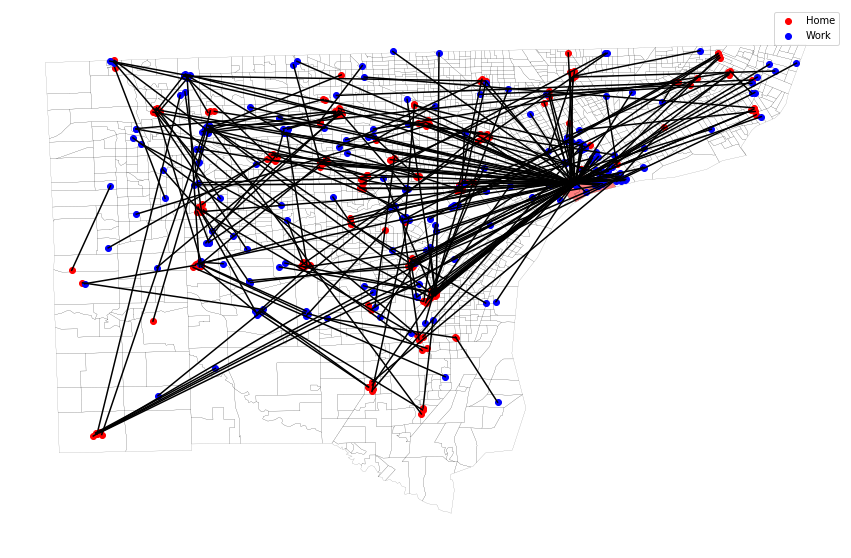

In [6]:
# =============================================================================
# Home location choice simulation using 2-stage model
# =============================================================================
top_n_pumas = None

# loading data and model
data = pickle.load(open(HOME_lOC_DATA_PATH, "rb"))
vacant_houses, floating_persons = data['houses'], data['persons']
FITTED_HOME_LOC_MODEL_PATH='./scripts/cities/'+city+'/models/home_loc_logit_2.p'
home_loc_logit=pickle.load( open( FITTED_HOME_LOC_MODEL_PATH, "rb" ) )

# adding PUMA info for new housing units 
for h in vacant_houses:
    if 'puma10' not in h:
        h['puma10'] = int_grid_to_puma[h['home_geoid']]
    h['puma10'] = str(h['puma10']).zfill(5)             

# simualtion
t1 = time.time()
home_location_choices_2(vacant_houses, floating_persons)
t2 = time.time()
time_2stage_all_pumas = t2 - t1
print('2-stage simulation: elapsed time is {:4.4f} seconds'.format(time_2stage_all_pumas))

# visulization
f, ax2 = plt.subplots(1, 1,figsize=(15,10))
get_LLs(floating_persons, ['home'])
all_zones_df.plot(ax = ax2, facecolor="none", edgecolor="black", linewidth=0.1)      
sim_zones_pd.plot(ax = ax2, facecolor='red', alpha=0.5, edgecolor="black", linewidth=0.1)
ax2.axis('off') 
ax2.axis('equal')
home_points, work_points, dist = [], [], []
for p in floating_persons:
    home_points.append(p['home_ll'])
    work_points.append(p['work_ll'])
    dist.append(get_haversine_distance(p['home_ll'], p['work_ll']))
home_points, work_points = np.asarray(home_points), np.asarray(work_points)
ax2.plot(home_points[:,0], home_points[:,1], 'o', color='red', label='Home')
ax2.plot(work_points[:,0], work_points[:,1], 'o', color='blue', label='Work')
commute_x = np.asarray([[home[0], work[0]] for home, work in zip(home_points, work_points)]).transpose()
commute_y = np.asarray([[home[1], work[1]] for home, work in zip(home_points, work_points)]).transpose()
ax2.plot(commute_x, commute_y, '-', color='black')
ax2.legend()
dist_2stage_all_pumas = np.array(dist).mean()
print('2-stage simulation mean work-home distance is: {}'.format(dist_2stage_all_pumas))
plt.show()

## 2-stage simulation: top_n_pumas=1

For PUMA level simulation, the floating person will always choose the PUMA with the largest probability. The same as pumas[argmax(probs)]

Floating persons tend to avoid distant houses as much as possible, and thus the mean distance is greatly reduced. 

2-stage simulation: elapsed time is 0.7715 seconds
2-stage simulation mean work-home distance is: 5506.503975323146


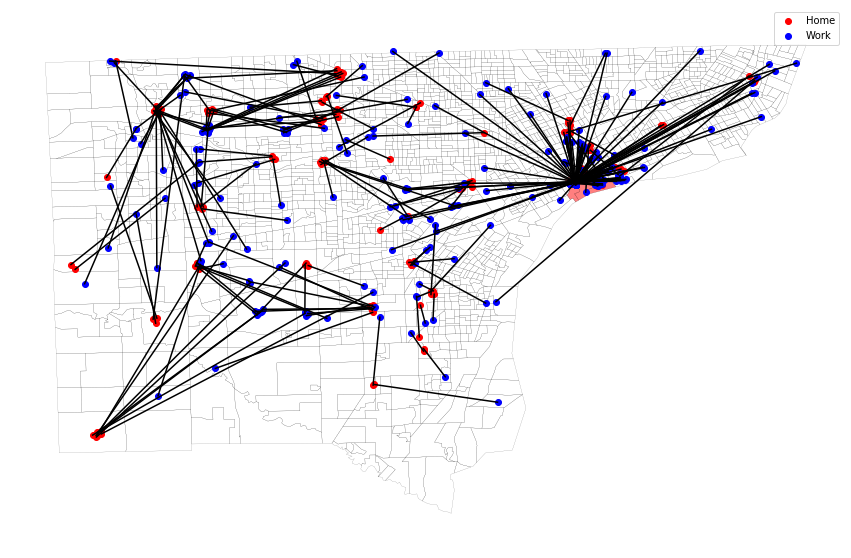

In [7]:
# =============================================================================
# Home location choice simulation using 2-stage model
# =============================================================================
top_n_pumas = 1

# loading data and model
data = pickle.load(open(HOME_lOC_DATA_PATH, "rb"))
vacant_houses, floating_persons = data['houses'], data['persons']
FITTED_HOME_LOC_MODEL_PATH='./scripts/cities/'+city+'/models/home_loc_logit_2.p'
home_loc_logit=pickle.load( open( FITTED_HOME_LOC_MODEL_PATH, "rb" ) )

# adding PUMA info for new housing units 
for h in vacant_houses:
    if 'puma10' not in h:
        h['puma10'] = int_grid_to_puma[h['home_geoid']]
    h['puma10'] = str(h['puma10']).zfill(5)             

# simualtion
t1 = time.time()
home_location_choices_2(vacant_houses, floating_persons)
t2 = time.time()
time_2stage_top1_pumas = t2 - t1
print('2-stage simulation: elapsed time is {:4.4f} seconds'.format(time_2stage_top1_pumas))

# visulization
f, ax2 = plt.subplots(1, 1,figsize=(15,10))
get_LLs(floating_persons, ['home'])
all_zones_df.plot(ax = ax2, facecolor="none", edgecolor="black", linewidth=0.1)      
sim_zones_pd.plot(ax = ax2, facecolor='red', alpha=0.5, edgecolor="black", linewidth=0.1)
ax2.axis('off') 
ax2.axis('equal')
home_points, work_points, dist = [], [], []
for p in floating_persons:
    home_points.append(p['home_ll'])
    work_points.append(p['work_ll'])
    dist.append(get_haversine_distance(p['home_ll'], p['work_ll']))
home_points, work_points = np.asarray(home_points), np.asarray(work_points)
ax2.plot(home_points[:,0], home_points[:,1], 'o', color='red', label='Home')
ax2.plot(work_points[:,0], work_points[:,1], 'o', color='blue', label='Work')
commute_x = np.asarray([[home[0], work[0]] for home, work in zip(home_points, work_points)]).transpose()
commute_y = np.asarray([[home[1], work[1]] for home, work in zip(home_points, work_points)]).transpose()
ax2.plot(commute_x, commute_y, '-', color='black')
ax2.legend()
dist_2stage_top1_pumas = np.array(dist).mean()
print('2-stage simulation mean work-home distance is: {}'.format(dist_2stage_top1_pumas))
plt.show()

## 2-stage simulation: top_n_pumas=5

For PUMA level simulation, it will calculate probabilities of all PUMAs, and only consider top 5 PUMAs with the largest probabilities.

Floating persons tend to avoid distant houses to some extend, the mean distance is reduced compared with 1-stage simulation, but not so much compared with 2-stage simulation & top_n_pumas=1. 

2-stage simulation: elapsed time is 0.7502 seconds
2-stage simulation mean work-home distance is: 7057.824885050511


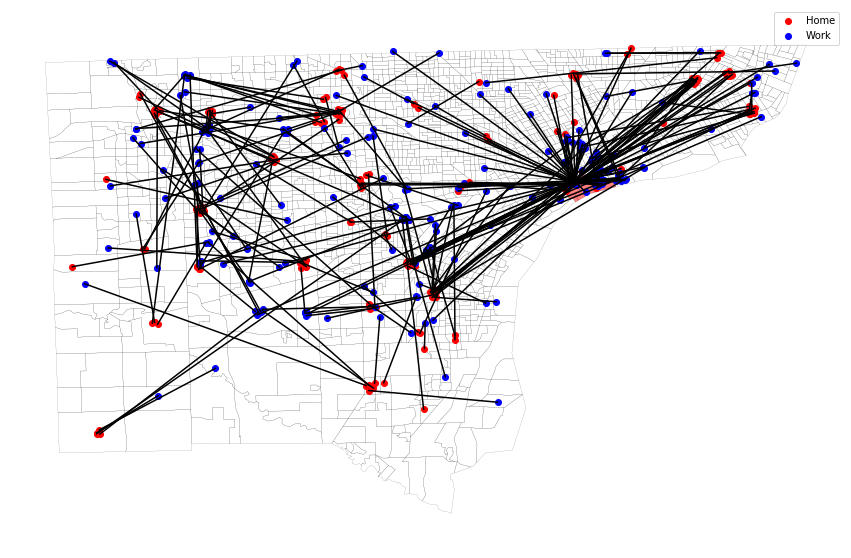

In [8]:
# =============================================================================
# Home location choice simulation using 2-stage model
# =============================================================================
top_n_pumas = 5

# loading data and model
data = pickle.load(open(HOME_lOC_DATA_PATH, "rb"))
vacant_houses, floating_persons = data['houses'], data['persons']
FITTED_HOME_LOC_MODEL_PATH='./scripts/cities/'+city+'/models/home_loc_logit_2.p'
home_loc_logit=pickle.load( open( FITTED_HOME_LOC_MODEL_PATH, "rb" ) )

# adding PUMA info for new housing units 
for h in vacant_houses:
    if 'puma10' not in h:
        h['puma10'] = int_grid_to_puma[h['home_geoid']]
    h['puma10'] = str(h['puma10']).zfill(5)             

# simualtion
t1 = time.time()
home_location_choices_2(vacant_houses, floating_persons)
t2 = time.time()
time_2stage_top5_pumas = t2 - t1
print('2-stage simulation: elapsed time is {:4.4f} seconds'.format(time_2stage_top5_pumas))

# visulization
f, ax2 = plt.subplots(1, 1,figsize=(15,10))
get_LLs(floating_persons, ['home'])
all_zones_df.plot(ax = ax2, facecolor="none", edgecolor="black", linewidth=0.1)      
sim_zones_pd.plot(ax = ax2, facecolor='red', alpha=0.5, edgecolor="black", linewidth=0.1)
ax2.axis('off') 
ax2.axis('equal')
home_points, work_points, hw_dist = [], [], []
for p in floating_persons:
    home_points.append(p['home_ll'])
    work_points.append(p['work_ll'])
    dist.append(get_haversine_distance(p['home_ll'], p['work_ll']))
home_points, work_points = np.asarray(home_points), np.asarray(work_points)
ax2.plot(home_points[:,0], home_points[:,1], 'o', color='red', label='Home')
ax2.plot(work_points[:,0], work_points[:,1], 'o', color='blue', label='Work')
commute_x = np.asarray([[home[0], work[0]] for home, work in zip(home_points, work_points)]).transpose()
commute_y = np.asarray([[home[1], work[1]] for home, work in zip(home_points, work_points)]).transpose()
ax2.plot(commute_x, commute_y, '-', color='black')
ax2.legend()
dist_2stage_top5_pumas = np.array(dist).mean()
print('2-stage simulation mean work-home distance is: {}'.format(dist_2stage_top5_pumas))
plt.show()

## Simulation considering dynamic availability of houses 

Use a for loop over all persons to make choices one by one. Once a house is chosen, it is no longer avaiable to other persons.

If the number of floating persons exceed vacant houses, add new houses by random sampling to fill the gap.

Set aside the choice outcomes, this approach takes too much time for a interactive simulation.

Total number of vacant houses: 313, total number of floating persons: 313
2-stage simulation considering dynamic availability: elapsed time is 6.5729 seconds
2-stage simulation mean work-home distance is: 9172.300278134056


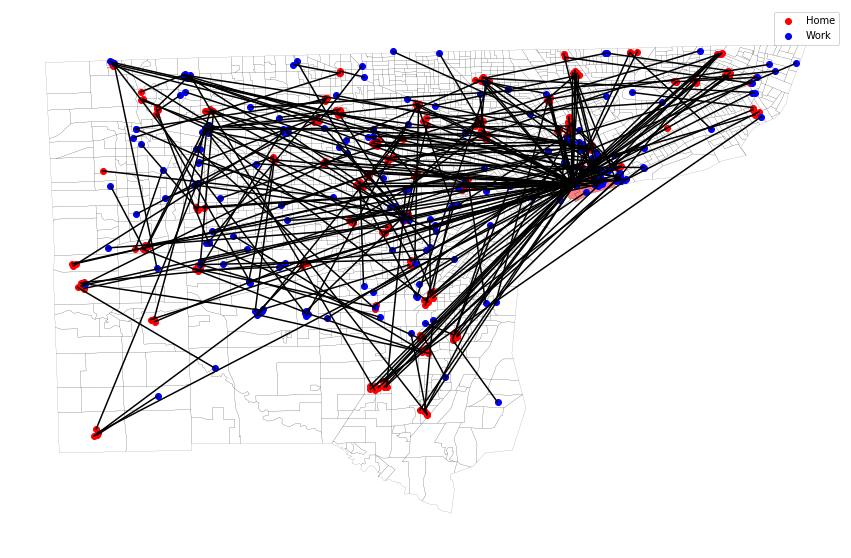

In [20]:
# loading data and model
data = pickle.load(open(HOME_lOC_DATA_PATH, "rb"))
vacant_houses, floating_persons = data['houses'], data['persons']
FITTED_HOME_LOC_MODEL_PATH='./scripts/cities/'+city+'/models/home_loc_logit_2.p'
home_loc_logit=pickle.load( open( FITTED_HOME_LOC_MODEL_PATH, "rb" ) )

# make sure there are enough houses to meat all floating persons: add new houses, or reduce floating persons
if len(floating_persons) > len(vacant_houses):
    add_new_houses = True
    if add_new_houses:
        base_houses = [h for h in vacant_houses if not h['home_geoid'].startswith('g')]
        for i in range(len(floating_persons)-len(vacant_houses)):
            tmp = copy.deepcopy(np.random.choice(base_houses))
            vacant_houses.append(tmp)
        for idx, h in enumerate(vacant_houses):
            h['house_id'] = idx
    else:
        floating_persons = list(np.random.choice(floating_persons, len(vacant_houses), replace=False))       
print('Total number of vacant houses: {}, total number of floating persons: {}'.format(len(vacant_houses), len(floating_persons)))

# add PUMA info for new housing units 
for h in vacant_houses:
    if 'puma10' not in h:
        h['puma10'] = int_grid_to_puma[h['home_geoid']]
    h['puma10'] = str(h['puma10']).zfill(5)
             
# shuffle floating persons and make simulations one by one, update vacant houses each time
t1 = time.time()
np.random.shuffle(floating_persons)
current_vacant_houses_dict = {}
for h in vacant_houses:
    current_vacant_houses_dict[h['house_id']] = copy.deepcopy(h)
for person in floating_persons:
    chosen_house_id = home_location_choices_for_single_person(current_vacant_houses_dict, person)
    current_vacant_houses_dict.pop(chosen_house_id) # delete chosen house for the next person
t2 = time.time()
time_2stage_loop = t2 - t1
print('2-stage simulation considering dynamic availability: elapsed time is {:4.4f} seconds'.format(time_2stage_loop))

# visulization
f, ax3 = plt.subplots(1, 1,figsize=(15,10))
get_LLs(floating_persons, ['home'])
all_zones_df.plot(ax = ax3, facecolor="none", edgecolor="black", linewidth=0.1)      
sim_zones_pd.plot(ax = ax3, facecolor='red', alpha=0.5, edgecolor="black", linewidth=0.1)
ax3.axis('off') 
ax3.axis('equal')
home_points, work_points, hw_dist = [], [], []
for p in floating_persons:
    home_points.append(p['home_ll'])
    work_points.append(p['work_ll'])
    dist.append(get_haversine_distance(p['home_ll'], p['work_ll']))
home_points, work_points = np.asarray(home_points), np.asarray(work_points)
ax3.plot(home_points[:,0], home_points[:,1], 'o', color='red', label='Home')
ax3.plot(work_points[:,0], work_points[:,1], 'o', color='blue', label='Work')
commute_x = np.asarray([[home[0], work[0]] for home, work in zip(home_points, work_points)]).transpose()
commute_y = np.asarray([[home[1], work[1]] for home, work in zip(home_points, work_points)]).transpose()
ax3.plot(commute_x, commute_y, '-', color='black')
ax3.legend()
dist_2stage_loop = np.array(dist).mean()
print('2-stage simulation mean work-home distance is: {}'.format(dist_2stage_loop))
plt.show()

## Another Data 

The following images are simulation results of another data. Here the floating persons and vacant houses are derived from the land use plan given by "cityIO_grid_data=[[int(i)] for i in np.random.randint(1,5,len(cityIO_grid_data))]". There are more persons and houses, with lots of them densely distributed in the interactive grids.

The left image is the outcomes of 1-stage simulation. Since lots of houses are located in the interactive grids, there are many long distance commuting connections.

The right image is the outcomes of 2-stage simulation, with top_n_pumas=5. Here the influential range of houses in the interactive grids is smaller, and long distance commutes are reduced.

![title](sim_compare.png)